<a href="https://colab.research.google.com/github/BielCandido/Sistemas-de-Apoio-Decis-o---Projeto-Pr-tico-II---NFL/blob/main/Draft_NFL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Estudo de Tendências e Fatores de Seleção no Draft da NFL**

## **1. Contextualização**

O Draft da National Football League (NFL) é um dos principais eventos do esporte nos Estados Unidos. Realizado anualmente, o processo tem como objetivo selecionar jogadores universitários para ingressar nas equipes da liga. A ordem das escolhas é definida de forma que o time com a pior campanha da temporada anterior tenha a primeira seleção, garantindo maior equilíbrio competitivo entre as franquias. Assim, rodada após rodada, as equipes escolhem novos atletas para reforçar seus elencos.

A análise dos dados do Draft permite compreender tendências relevantes, como as posições mais valorizadas, as universidades que mais formam jogadores selecionados e a relação de características físicas e demográficas com a escolha. Neste trabalho, o objetivo é explorar uma base de dados contendo informações de diversos Drafts da NFL para identificar padrões e fatores que podem influenciar o processo de seleção de jogadores.

# **1. Importação das bibliotecas**

In [1]:

import numpy as np # Biblioteca fundamental para operações numéricas em Python, como criação de arrays e matrizes.
import pandas as pd # Biblioteca para manipulação e análise de dados, utilizada para criar e manipular DataFrames.
import seaborn as sns # Biblioteca para visualização de dados, oferecendo uma interface de alto nível para criar gráficos estatísticos.
import networkx as nx # Biblioteca para criação e manipulação de grafos, útil para visualizar relações entre dados.
import matplotlib.cm as cm # Biblioteca para criação de mapas de cores personalizados.
import plotly.express as px # Biblioteca para criação de gráficos interativos, oferecendo uma ampla variedade de visualizações.
import matplotlib.pyplot as plt # Biblioteca para criação de gráficos estáticos, oferecendo um conjunto completo de ferramentas para visualização de dados.
import plotly.graph_objects as go # Biblioteca para criação de gráficos interativos complexos.
from itertools import combinations # Biblioteca para gerar todas as combinações possíveis de elementos em um iterável.
from sklearn.cluster import KMeans # Biblioteca para implementar o algoritmo de clustering K-means.
from sklearn.decomposition import PCA # Biblioteca para realizar Análise de Componentes Principais (PCA), uma técnica de redução de dimensionalidade.
from sklearn.metrics import silhouette_score # Biblioteca para calcular a métrica Silhouette, utilizada para avaliar a qualidade dos clusters.
from sklearn.metrics import silhouette_samples # Biblioteca para calcular os coeficientes de silhouette para cada amostra.
from sklearn.preprocessing import MinMaxScaler # Biblioteca para escalonar os dados, colocando todas as features em uma mesma escala.
print('Bibliotecas carregadas com sucesso')

Bibliotecas carregadas com sucesso


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
caminho_arquivo = '/content/drive/MyDrive/Colab Notebooks/draft.xlsx'
df = pd.read_excel(caminho_arquivo)

# **2. Seleção das colunas de interesse**


*   Iniciamos nosso trabalho selecionando as colunas do nosso conjunto de dados que eram mais relevantes para entender o perfil dos jogadores draftados e o processo de seleção. As colunas escolhidas incluíram informações sobre o time que draftou (draftTeam), a faculdade de origem (college), a posição jogada (position), atributos físicos como altura (heightInches) e peso (weight), a idade do jogador no draft (ageAtDraft) e a rodada em que foi selecionado (round).

*   Em seguida, realizamos um importante passo de limpeza e pré-processamento dos dados. Convertemos as colunas numéricas para garantir o formato correto e preenchemos valores ausentes ou zeros (que consideramos inválidos para altura, peso, idade e rodada) para garantir que nossa análise fosse feita em dados consistentes. Removemos as linhas com dados faltantes para ter um conjunto de dados completo para as análises subsequentes.

In [4]:
import pandas as pd
import numpy as np

# --- ETAPA DE CARREGAMENTO DOS DADOS ---

# --- Etapa 1: Selecionar as colunas de interesse ---
colunas_interesse = [
    'draftTeam',
    'college',
    'position',
    'heightInches',
    'weight',
    'ageAtDraft',
    'round'
]
df_analise = df[colunas_interesse].copy()

# --- Etapa 2: LIMPEZA E PREENCHIMENTO COM ZERO ---

# 2.1 - Converter colunas numéricas, transformando erros em NaN
colunas_numericas = ['heightInches', 'weight', 'ageAtDraft', 'round']
for col in colunas_numericas:
    df_analise[col] = pd.to_numeric(df_analise[col], errors='coerce')

# 2.2 - Preencher os nulos
valores_para_preencher = {
    'heightInches': 0, 'weight': 0, 'ageAtDraft': 0, 'round' : 0,
    'college': 'Desconhecido', 'position': 'Desconhecido', 'draftTeam': 'Desconhecido'
}
df_analise.fillna(value=valores_para_preencher, inplace=True)

# 2.3 - Garantir os tipos de dados corretos
df_analise['round'] = df_analise['round'].astype(int)
df_analise['heightInches'] = df_analise['heightInches'].astype(float)
df_analise['weight'] = df_analise['weight'].astype(float)
df_analise['ageAtDraft'] = df_analise['ageAtDraft'].astype(float)

# **3. Análise Descritiva**


*   Partimos para uma análise descritiva para entender as características gerais dos jogadores no nosso conjunto de dados limpo.

*   Identificamos as posições mais frequentemente draftadas na liga, as faculdades que mais enviaram jogadores para o Draft e os times que mais realizaram seleções ao longo dos anos.

*   Exploramos visualmente a relação entre os atributos físicos dos jogadores (altura, peso, idade e rodada) através de gráficos de dispersão, que nos deram uma ideia inicial de como esses atributos se relacionam e se diferenciam por posição.

*   Geramos gráficos de barras para visualizar a distribuição das posições mais comuns por rodada, e boxplots para observar a distribuição de altura, peso e idade em cada rodada do draft.

In [5]:
# --- Etapa 3: Análise Descritiva Final ---

print("--- Informações Gerais do DataFrame Final ---")
df_analise.info()

--- Informações Gerais do DataFrame Final ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12140 entries, 0 to 12139
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   draftTeam     12140 non-null  object 
 1   college       12140 non-null  object 
 2   position      12140 non-null  object 
 3   heightInches  12140 non-null  float64
 4   weight        12140 non-null  float64
 5   ageAtDraft    12140 non-null  float64
 6   round         12140 non-null  int64  
dtypes: float64(3), int64(1), object(3)
memory usage: 664.0+ KB


## **3.1 Frequência para Tendências**

### 3.1.1 Posições mais draftadas

In [6]:
# Contar as posições mais draftadas
print("--- Posições mais frequentes no Draft (Top 10) ---")
display(df_analise['position'].value_counts().head(10))

--- Posições mais frequentes no Draft (Top 10) ---


,count
position,
LB,1549
DB,1489
WR,1481
RB,1219
DE,980
OT,873
DT,771
OG,766
TE,689


### 3.1.2 Faculdades que mais fornecem jogadores

In [7]:
# Contar as faculdades que mais forneceram jogadores
print("--- Faculdades com mais jogadores draftados (Top 10) ---")
display(df_analise['college'].value_counts().head(10))

--- Faculdades com mais jogadores draftados (Top 10) ---


,count
college,
USC,255
Miami (FL),246
Ohio State,238
Florida,223
Penn State,222
Notre Dame,220
Florida State,215
Nebraska,213
Alabama,213


### 3.1.3 Times que mais draftam jogares

In [ ]:
# Contar os times que mais selecionaram jogadores
print("--- Times com mais seleções no Draft (Top 10) ---")
display(df_analise['draftTeam'].value_counts().head(10))

--- Times com mais seleções no Draft (Top 10) ---


,count
draftTeam,
CIN,460
PIT,453
NE,452
GB,439
DAL,436
BUF,423
MIA,420
NYJ,414
TB,406


## **3.2 Visualização das Relações**

--- Gerando Gráfico de Dispersão (Pairplot) ---


Text(0.5, 1.02, 'Relação entre Atributos Físicos por Posição (Amostra)')

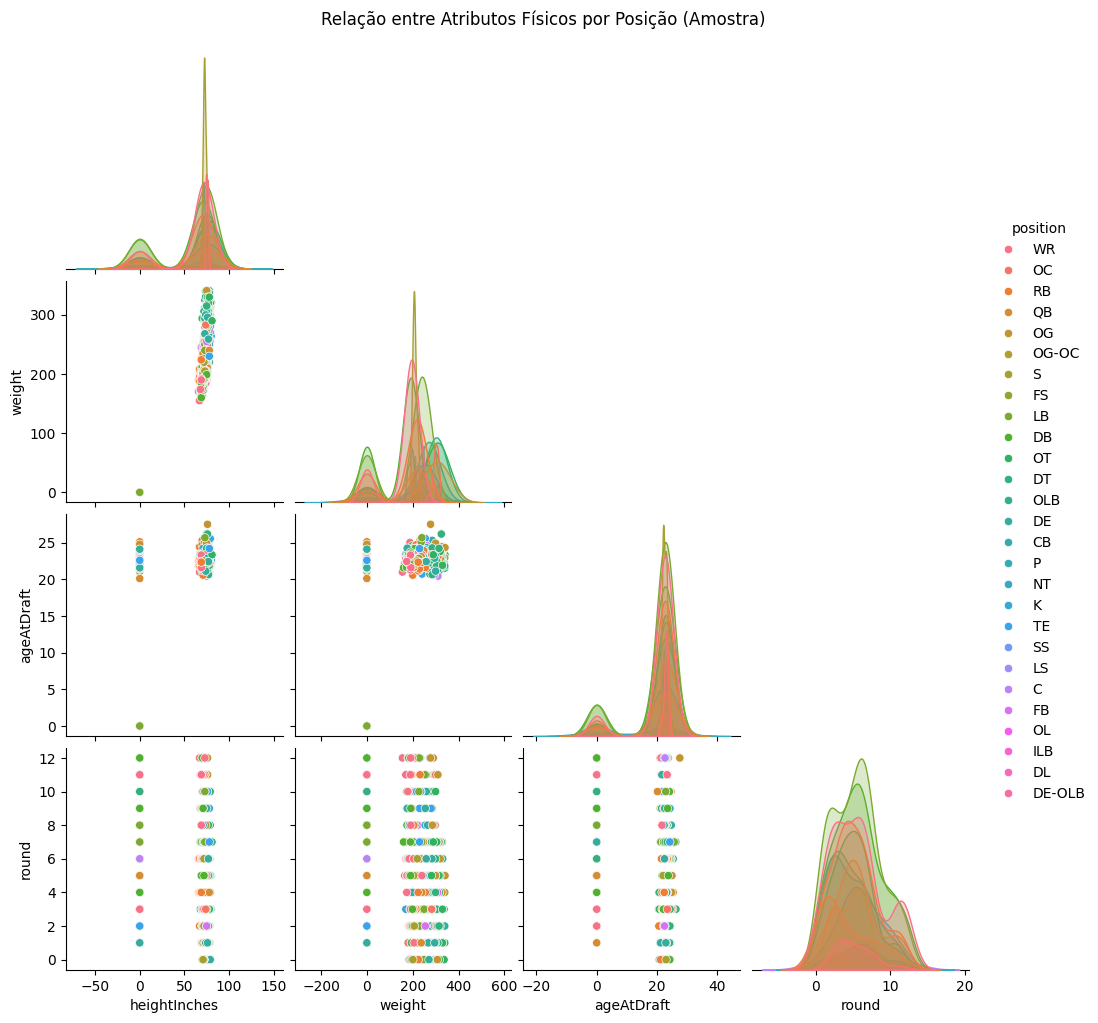

In [8]:
print("--- Gerando Gráfico de Dispersão (Pairplot) ---")
# Criando um pairplot para visualizar a relação entre as variáveis numéricas,
# colorindo os pontos pela 'posição' do jogador.
# Usamos uma amostra de 1000 jogadores para o gráfico carregar mais rápido.
sns.pairplot(df_analise.sample(n=1000, random_state=1), hue='position', corner=True)
plt.suptitle('Relação entre Atributos Físicos por Posição (Amostra)', y=1.02)
# plt.show() # Em um notebook, o gráfico aparecerá. Se for um script .py, descomente esta linha.

### 3.2.1 Visualização

--- Gerando Gráfico de Posições por Rodada ---


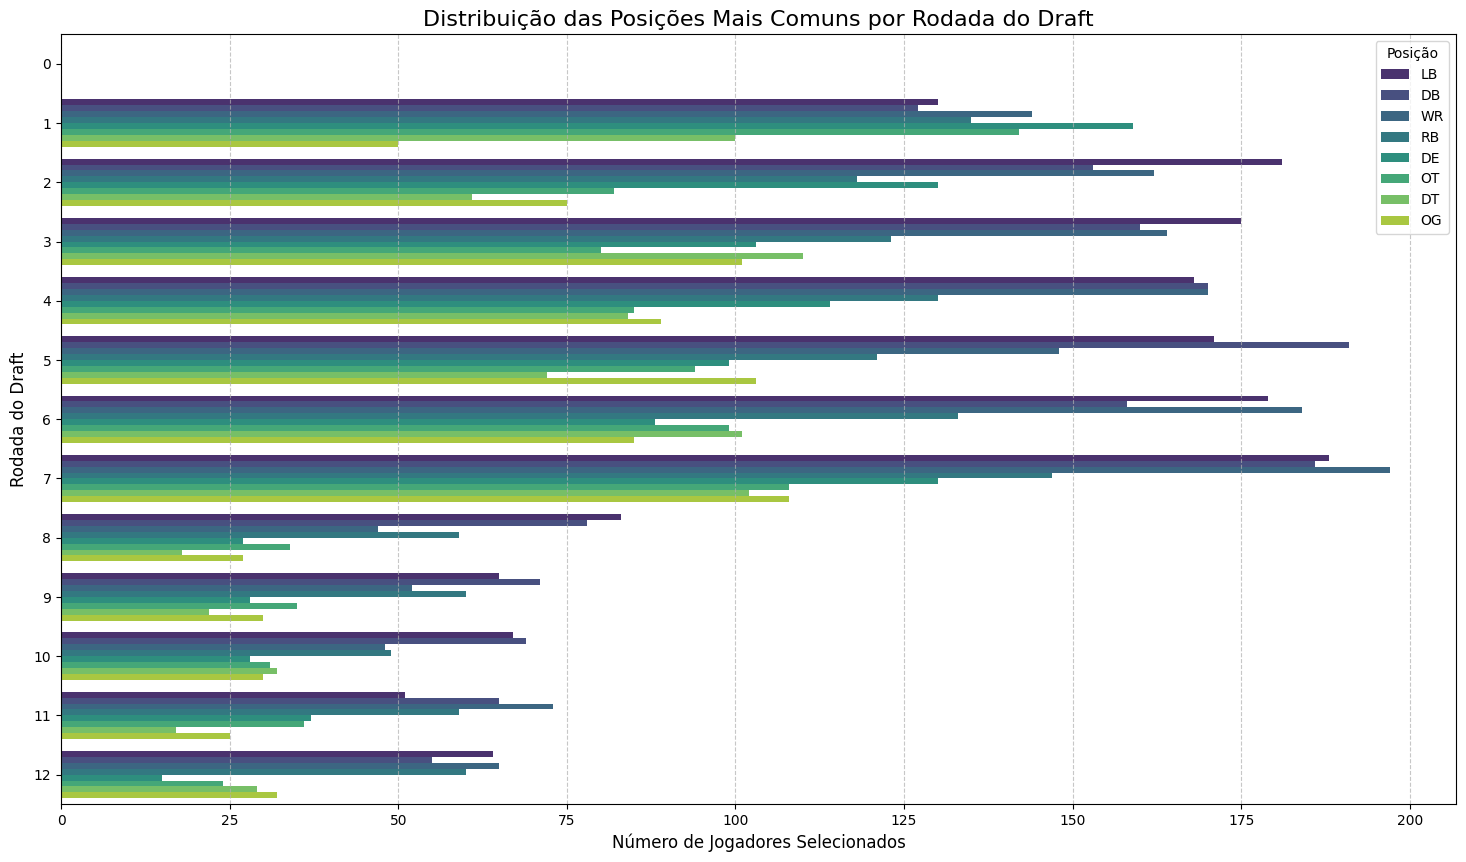



--- Gerando Gráficos de Boxplot de Atributos Físicos por Rodada ---


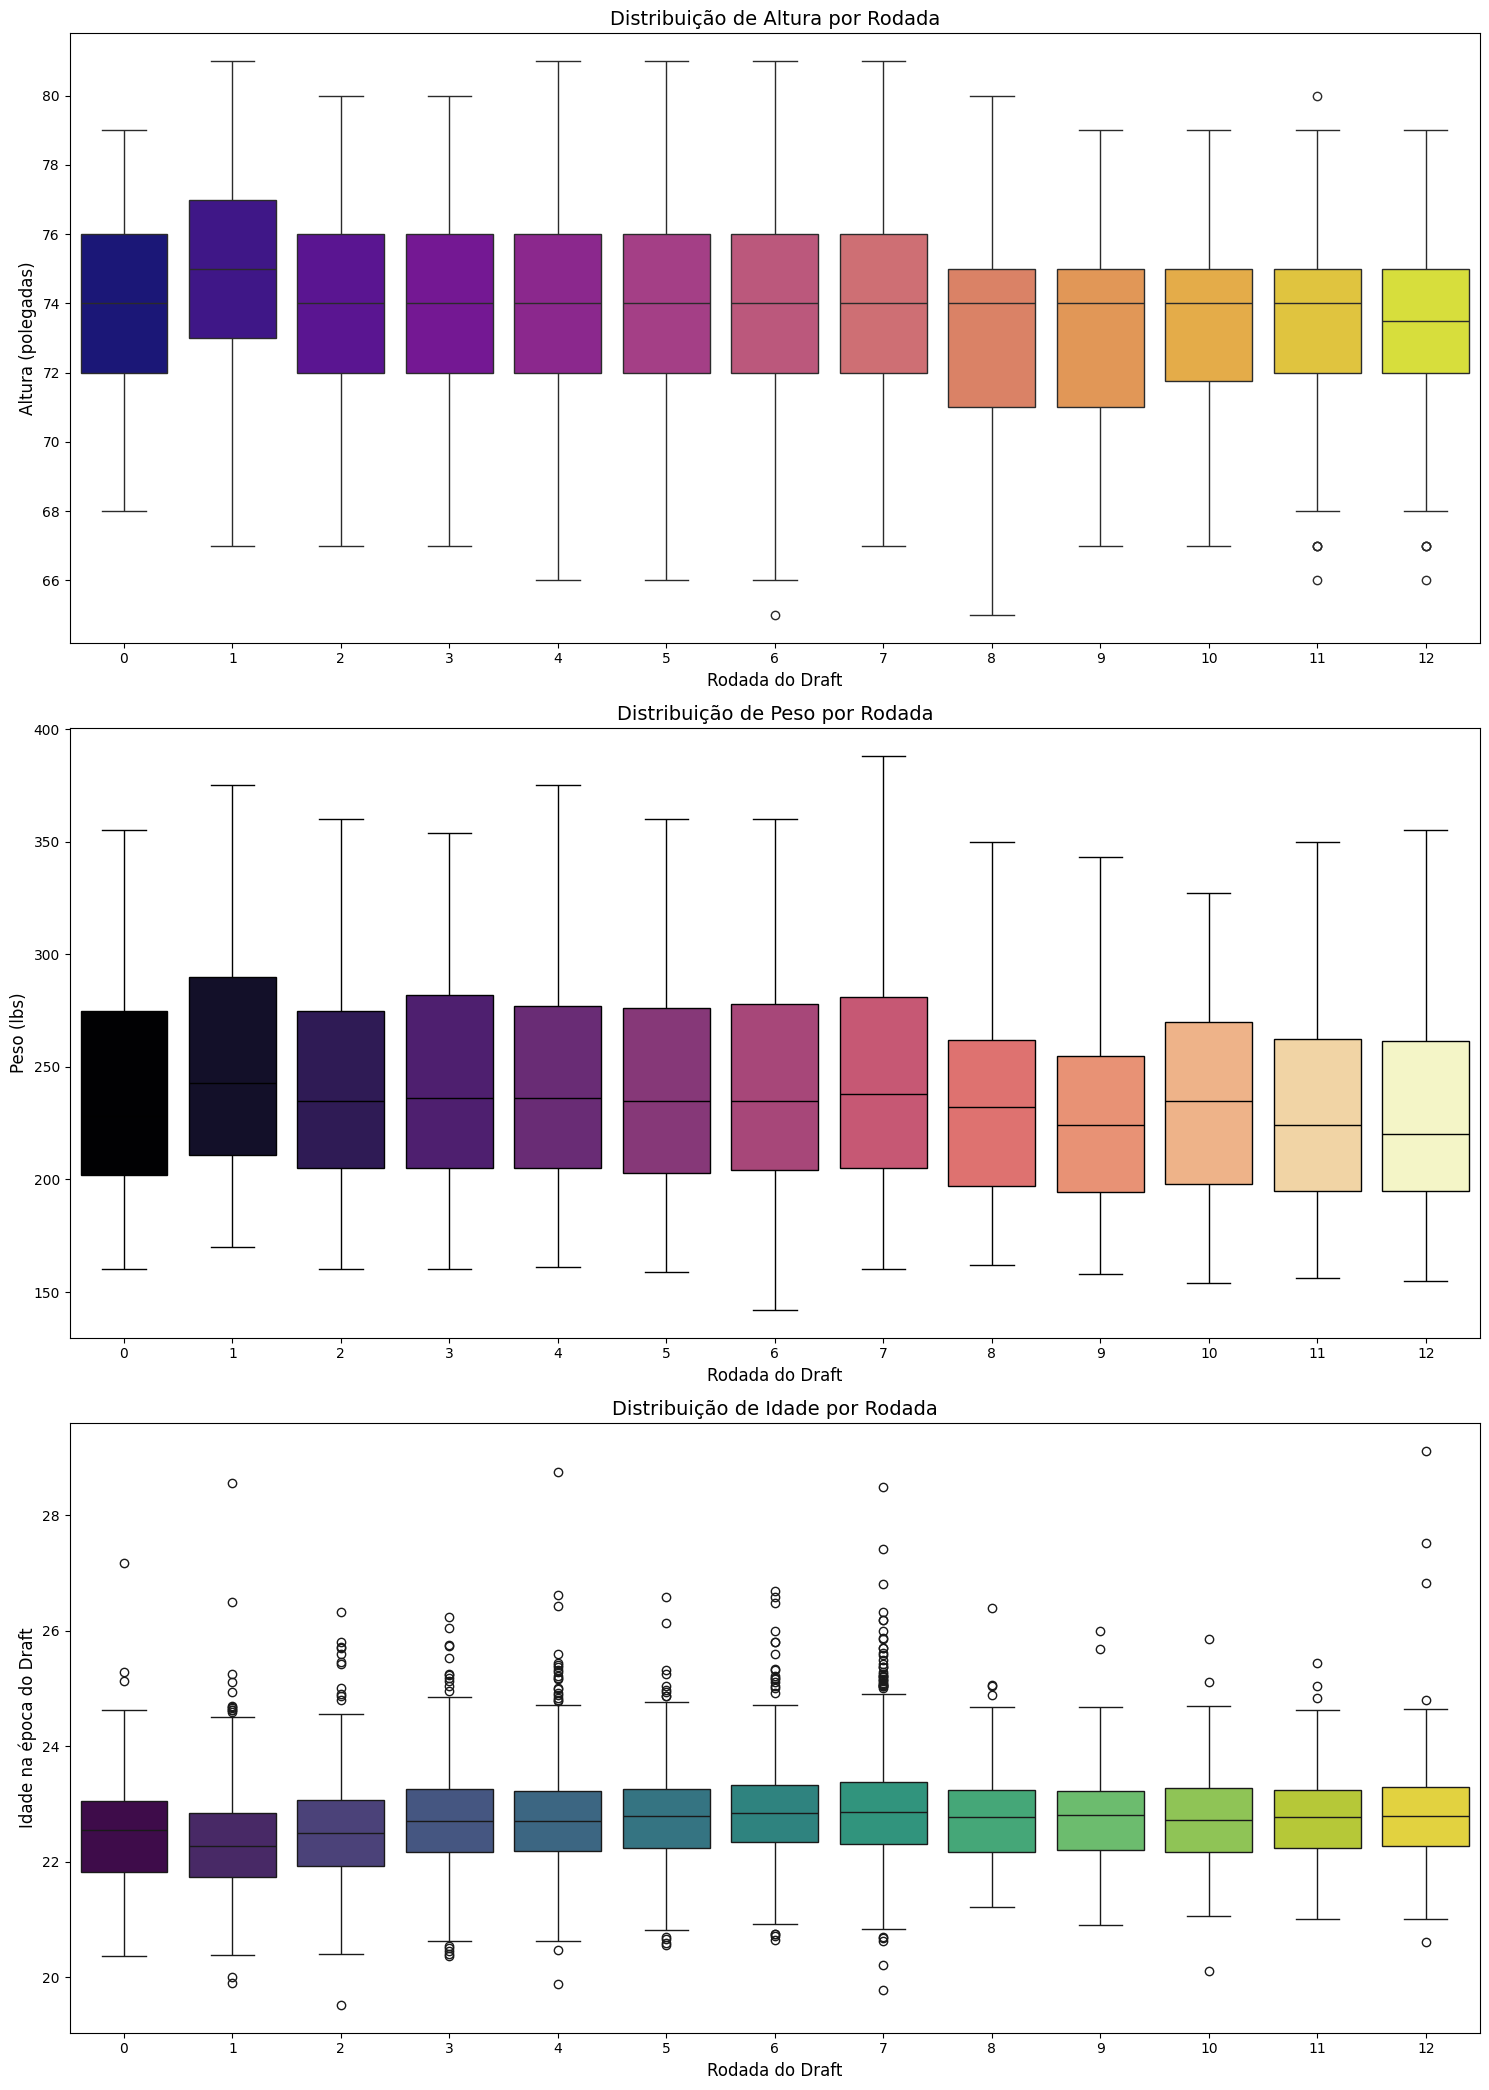

In [10]:
print("--- Gerando Gráfico de Posições por Rodada ---")
plt.figure(figsize=(18, 10))
sns.countplot(data=df_analise[df_analise['round'] > 0], y='round', hue='position',
              order=sorted(df_analise['round'].unique()),
              hue_order=df_analise['position'].value_counts().head(8).index,
              orient='h', palette='viridis')
plt.title('Distribuição das Posições Mais Comuns por Rodada do Draft', fontsize=16)
plt.xlabel('Número de Jogadores Selecionados', fontsize=12)
plt.ylabel('Rodada do Draft', fontsize=12)
plt.legend(title='Posição')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# --- Gerando Gráficos de Boxplot de Atributos Físicos por Rodada (Verticalmente) ---
print("\n" + "="*50 + "\n")
print("--- Gerando Gráficos de Boxplot de Atributos Físicos por Rodada ---")

# MUDANÇA AQUI: de (1, 3) para (3, 1) para criar 3 linhas e 1 coluna.
# Ajustamos também o figsize para um layout vertical mais agradável.
fig, axes = plt.subplots(3, 1, figsize=(15, 21))

# Boxplot para Altura (no primeiro subplot)
# CORREÇÃO: Atribuindo 'x' a 'hue' e definindo legend=False para remover FutureWarning
sns.boxplot(data=df_analise[df_analise['heightInches'] > 0], x='round', y='heightInches', ax=axes[0], palette='plasma', hue='round', legend=False)
axes[0].set_title('Distribuição de Altura por Rodada', fontsize=14)
axes[0].set_xlabel('Rodada do Draft', fontsize=12)
axes[0].set_ylabel('Altura (polegadas)', fontsize=12)

# Boxplot para Peso (no segundo subplot)
# CORREÇÃO: Atribuindo 'x' a 'hue' e definindo legend=False para remover FutureWarning
sns.boxplot(data=df_analise[df_analise['weight'] > 0], x='round', y='weight', ax=axes[1], palette='magma', hue='round', legend=False)
axes[1].set_title('Distribuição de Peso por Rodada', fontsize=14)
axes[1].set_xlabel('Rodada do Draft', fontsize=12)
axes[1].set_ylabel('Peso (lbs)', fontsize=12)

# Boxplot para Idade (no terceiro subplot)
# CORREÇÃO: Atribuindo 'x' a 'hue' e definindo legend=False para remover FutureWarning
sns.boxplot(data=df_analise[df_analise['ageAtDraft'] > 0], x='round', y='ageAtDraft', ax=axes[2], palette='viridis', hue='round', legend=False)
axes[2].set_title('Distribuição de Idade por Rodada', fontsize=14)
axes[2].set_xlabel('Rodada do Draft', fontsize=12)
axes[2].set_ylabel('Idade na época do Draft', fontsize=12)

plt.tight_layout()
plt.show()

# **4. Agrupamento (Clustering)**


*   Com o objetivo de identificar grupos de jogadores com perfis semelhantes, aplicamos técnicas de agrupamento.

*   Utilizamos a Análise de Componentes Principais (PCA) para reduzir a dimensionalidade dos nossos dados, transformando as várias características dos jogadores em um número menor de componentes principais, preservando a maior parte da informação relevante. Analisamos a variância explicada pelos componentes para decidir quantos reter para a etapa de agrupamento.

*   Determinamos o número ideal de clusters utilizando o Método do Cotovelo (Elbow Method) e a Análise da Silhueta (Silhouette Analysis), que nos ajudaram a avaliar a coesão e separação dos grupos. Definimos que 4 clusters seriam adequados para a nossa análise.

*   Aplicamos o algoritmo K-Means para agrupar os jogadores nos 4 clusters identificados, adicionando uma nova coluna 'Cluster' ao nosso conjunto de dados para identificar a qual grupo cada jogador pertence.



## Análise de Componentes Principais - PCA

A Análise de Componentes Principais (PCA, do inglês Principal Component Analysis) é uma técnica estatística de redução de dimensionalidade. Seu objetivo é simplificar conjuntos de dados que possuem muitas variáveis, transformando-as em um número menor de componentes principais sem perder informações relevantes.

## 4.1 Aplicação do PCA

--- Análise da Variação dos Componentes Principais ---
    Componente  Variação Explicada  Variação Acumulada
0            1            0.057366            0.057366
1            2            0.024006            0.081372
2            3            0.023730            0.105103
3            4            0.023512            0.128615
4            5            0.023182            0.151797
5            6            0.022679            0.174476
6            7            0.022450            0.196926
7            8            0.022225            0.219151
8            9            0.022187            0.241339
9           10            0.021958            0.263297
10          11            0.021657            0.284954
11          12            0.021470            0.306425
12          13            0.021258            0.327682
13          14            0.021099            0.348781
14          15            0.021072            0.369853
15          16            0.021061            0.390914
16        

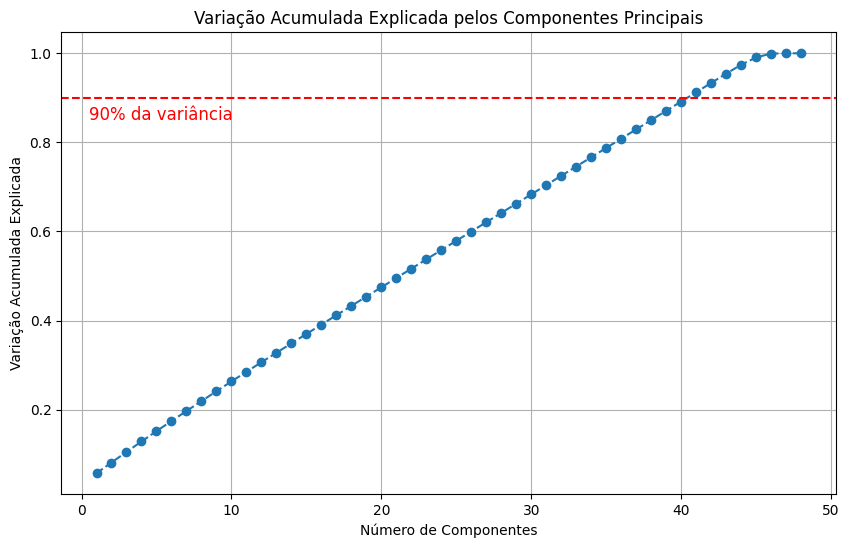

In [13]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# --- Etapa 1: Preparação dos Dados para o PCA ---

# Vamos usar o DataFrame 'df_analise' que preparamos anteriormente
# Selecionamos apenas os atributos que definem o perfil de um jogador
# (Excluímos 'draftTeam' e 'college' por enquanto, pois são categorias com muitas variações)
colunas_pca = ['position', 'heightInches', 'weight', 'ageAtDraft', 'round']
df_pca_source = df_analise[colunas_pca].copy()

# 1.1 - One-Hot Encoding para a coluna 'position'
# Isso cria uma nova coluna para cada posição (ex: position_QB, position_WR) com valores 0 ou 1
df_pca_encoded = pd.get_dummies(df_pca_source, columns=['position'], drop_first=True)

# 1.2 - Padronização dos Dados (Scaling)
# O PCA é sensível à escala das variáveis, então padronizamos todas para terem média 0 e desvio padrão 1.
scaler = StandardScaler()
dados_scaled = scaler.fit_transform(df_pca_encoded)


# --- Etapa 2: Aplicação do PCA ---

# Instanciamos o PCA. Não definimos o número de componentes ainda para analisar todos.
pca = PCA()
componentes_principais = pca.fit_transform(dados_scaled)


# --- Etapa 3: Análise da Variância Explicada ---

# Variação explicada por cada componente individualmente
variancia_explicada = pca.explained_variance_ratio_

# Variação explicada acumulada
variancia_acumulada = np.cumsum(variancia_explicada)

# Criando um DataFrame para visualizar os resultados
df_variancia = pd.DataFrame({
    "Componente": range(1, len(variancia_explicada) + 1),
    "Variação Explicada": variancia_explicada,
    "Variação Acumulada": variancia_acumulada
})

print("--- Análise da Variação dos Componentes Principais ---")
print(df_variancia)


# --- Etapa 4: Visualização da Variação Acumulada (Gráfico de Cotovelo) ---

plt.figure(figsize=(10, 6))
plt.plot(df_variancia["Componente"], df_variancia["Variação Acumulada"], marker='o', linestyle='--')
plt.title('Variação Acumulada Explicada pelos Componentes Principais')
plt.xlabel('Número de Componentes')
plt.ylabel('Variação Acumulada Explicada')
plt.grid(True)
# Linha para marcar 90% da variância, um limiar comum
plt.axhline(y=0.90, color='r', linestyle='--')
plt.text(0.5, 0.85, '90% da variância', color = 'red', fontsize=12)
plt.show()


### 4.1.1 Dataframe Final para o agrupamento

In [14]:
from sklearn.decomposition import PCA
import pandas as pd

# Supondo que a variável 'dados_scaled' do passo anterior ainda está na memória

# Definimos o número de componentes que decidimos usar com base na nova tabela
n_componentes_final = 41

# Aplicamos o PCA novamente, especificando o número de componentes
pca_final = PCA(n_components=n_componentes_final)
componentes_principais_final = pca_final.fit_transform(dados_scaled)

# Criamos o DataFrame final que será usado para a clusterização
df_para_cluster = pd.DataFrame(data=componentes_principais_final,
                               columns=[f'Componente_{i}' for i in range(1, n_componentes_final + 1)])

print("DataFrame criado com sucesso para a etapa de clusterização!")
print(f"Shape (formato) do novo DataFrame: {df_para_cluster.shape}")
display(df_para_cluster.head())

DataFrame criado com sucesso para a etapa de clusterização!
Shape (formato) do novo DataFrame: (12140, 41)


,Componente_1,Componente_2,Componente_3,Componente_4,Componente_5,Componente_6,Componente_7,Componente_8,Componente_9,Componente_10,...,Componente_32,Componente_33,Componente_34,Componente_35,Componente_36,Componente_37,Componente_38,Componente_39,Componente_40,Componente_41
0,0.679158,0.050876,0.131810,-1.461128,2.416086,-1.123488,0.072935,0.169241,-0.379083,-0.543370,...,0.004877,-0.002030,9.675908e-13,2.214779e-13,4.110818e-13,8.367385e-13,-1.669823e-13,-4.650759e-13,5.670438e-13,1.140678e-12
1,0.541121,0.084919,0.123951,-1.433274,2.444452,-1.135333,0.071183,0.159081,-0.374975,-0.536521,...,0.005033,-0.002021,9.466648e-13,2.069400e-13,3.983801e-13,8.402739e-13,-1.561247e-13,-4.751616e-13,5.622074e-13,1.139859e-12
2,1.499406,0.117762,0.342879,-0.096667,1.221669,3.155924,-0.802296,0.365052,0.095709,-0.242678,...,0.002853,-0.001433,4.058338e-13,3.530129e-14,2.180739e-13,5.137278e-13,9.236096e-15,-3.314033e-13,3.387574e-13,6.133953e-13
3,1.455584,-0.462299,0.386315,-0.791773,-0.532833,0.682406,3.430553,-0.083400,0.052454,-0.085823,...,0.002025,-0.002056,2.675993e-13,-5.795874e-14,1.474281e-13,5.588718e-13,9.494878e-14,-4.344146e-13,3.329446e-13,6.505470e-13
4,1.446778,0.103926,0.345221,-0.109050,1.216407,3.170161,-0.797760,0.370976,0.093569,-0.240524,...,0.002742,-0.001417,4.050133e-13,3.944858e-14,2.203559e-13,5.045364e-13,6.753707e-15,-3.233455e-13,3.359220e-13,6.032559e-13


## **4.2 Análise Gráfica de Variação Explicada**

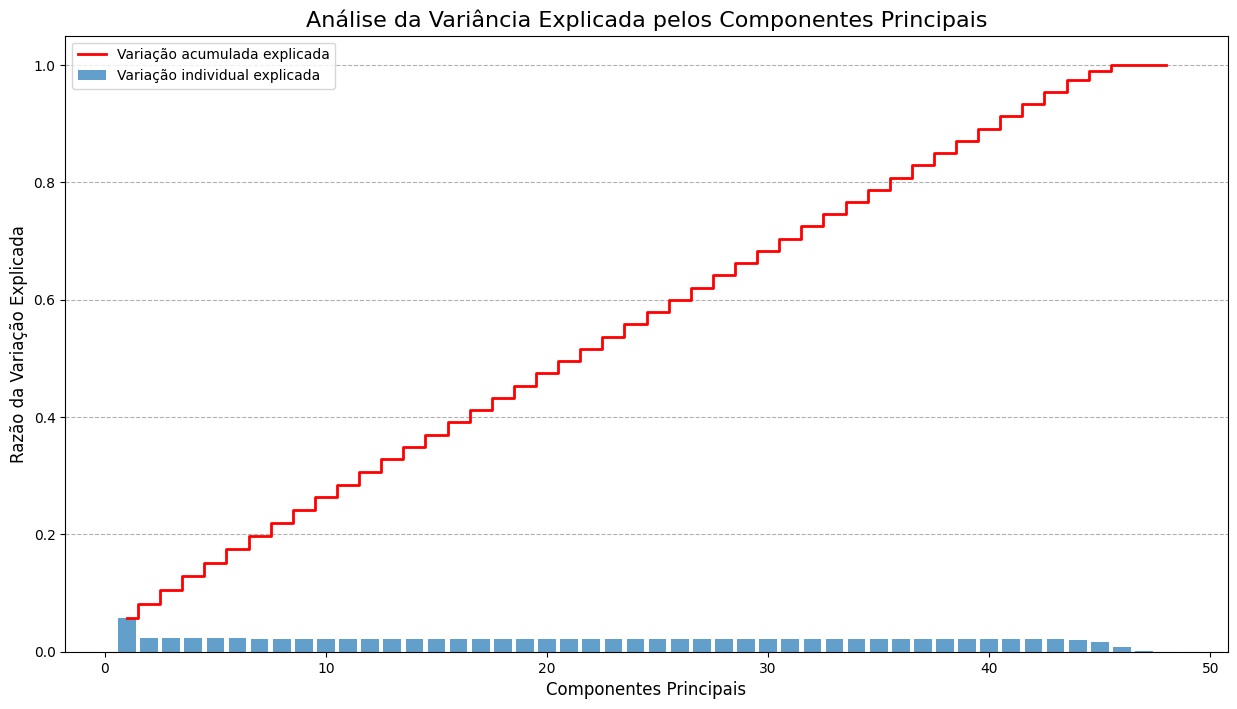

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Supondo que as variáveis 'variancia_explicada' e 'variancia_acumulada'
# do passo anterior (cálculo do PCA) ainda estão na memória.

# Criando o gráfico com um tamanho maior para melhor visualização
plt.figure(figsize=(15, 8))

# Gráfico de barras para a variância individual explicada
plt.bar(range(1, len(variancia_explicada) + 1), variancia_explicada, alpha=0.7, align='center',
        label='Variação individual explicada')

# Gráfico de linha (degraus) para a variância acumulada
plt.step(range(1, len(variancia_acumulada) + 1), variancia_acumulada, where='mid',
         label='Variação acumulada explicada', color='red', linewidth=2)

plt.ylabel('Razão da Variação Explicada', fontsize=12)
plt.xlabel('Componentes Principais', fontsize=12)
plt.title('Análise da Variância Explicada pelos Componentes Principais', fontsize=16)
plt.legend(loc='best')
plt.grid(axis='y', linestyle='--')
plt.show()

## **4.3 Número ideal de Clursters - Elbow Method**

O objetivo aqui é descobrir quantos "grupos" ou "perfis" de jogadores existem naturalmente nos seus dados. Faremos isso testando diferentes números de clusters (de 1 a 15, por exemplo) e medindo o quão bem os jogadores ficam agrupados em cada cenário.

### 4.3.1 Aplicação Método do Cotovelo (Elbow Method)

Calculando o WCSS para cada número de clusters (de 1 a 15)...
Cálculo finalizado.


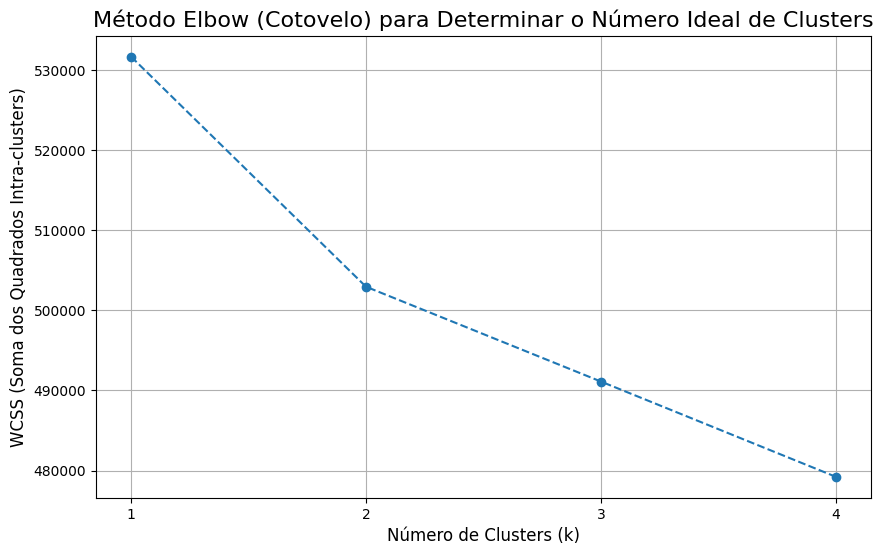

In [16]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Lista para armazenar o WCSS (Within-Cluster Sum of Squares) para cada número de clusters
wcss = []
max_clusters = 4

print("Calculando o WCSS para cada número de clusters (de 1 a 15)...")

for i in range(1, max_clusters + 1):
    # Cria e treina o modelo KMeans com 'i' clusters
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init=10, random_state=42)
    kmeans.fit(df_para_cluster)
    # Adiciona o valor do WCSS (inertia_) à lista
    wcss.append(kmeans.inertia_)

print("Cálculo finalizado.")


# --- Visualização Gráfica do Método Elbow ---

plt.figure(figsize=(10, 6))
plt.plot(range(1, max_clusters + 1), wcss, marker='o', linestyle='--')
plt.title('Método Elbow (Cotovelo) para Determinar o Número Ideal de Clusters', fontsize=16)
plt.xlabel('Número de Clusters (k)', fontsize=12)
plt.ylabel('WCSS (Soma dos Quadrados Intra-clusters)', fontsize=12)
plt.xticks(range(1, max_clusters + 1))
plt.grid(True)
plt.show()

## **4.4 Algoritmo K-Means**

Nesta etapa, o objetivo é aplicar o algoritmo de agrupamento K-Means aos dados transformados pela Análise de Componentes Principais (PCA). A meta é identificar grupos de jogadores com perfis semelhantes com base em seus atributos físicos, de posição e desempenho no draft.

O que é o K-Means?
O K-Means é um dos algoritmos de aprendizado de máquina não supervisionado mais populares, utilizado para clusterização. Seu principal objetivo é particionar um conjunto de dados em K clusters (grupos) distintos e não sobrepostos.

A lógica do algoritmo é agrupar os pontos de dados de forma que a variação dentro de cada cluster seja a menor possível. Em outras palavras, ele tenta criar grupos onde os membros são muito parecidos entre si, mas bem diferentes dos membros de outros grupos. A "similaridade" entre os pontos de dados é medida pela distância entre eles, geralmente a distância euclidiana.

### 4.4.1 Aplicação do Algoritmo K-Means

In [17]:
from sklearn.cluster import KMeans
import pandas as pd

# Supondo que o DataFrame 'df_para_cluster' (do PCA) e o 'df_analise' ainda estão na memória.

# Definimos o número de clusters que encontramos no Método Elbow
n_clusters_final = 4
# Cria e treina o modelo K-Means com 4 clusters
# init='k-means++' : ajuda a inicializar os centróides de forma mais inteligente
# n_init=10 : executa o algoritmo 10 vezes com diferentes centróides e escolhe o melhor resultado
# random_state=42 : garante que os resultados sejam os mesmos toda vez que você rodar o código
kmeans = KMeans(n_clusters=n_clusters_final, init='k-means++', n_init=10, random_state=42)
clusters = kmeans.fit_predict(df_para_cluster)

# Adiciona a nova coluna 'Cluster' ao DataFrame de análise principal
df_analise['Cluster'] = clusters

# --- Resultados do Agrupamento ---

print(f"--- Jogadores agrupados em {n_clusters_final} clusters ---")

# Mostra a contagem de jogadores em cada cluster
print("\nContagem de jogadores por cluster:")
print(df_analise['Cluster'].value_counts())

# Mostra as primeiras linhas do DataFrame com a nova coluna 'Cluster'
print("\nExemplo do DataFrame com a coluna 'Cluster':")
display(df_analise.head())

--- Jogadores agrupados em 4 clusters ---

Contagem de jogadores por cluster:
Cluster
2    9468
1    2544
0     126
3       2
Name: count, dtype: int64

Exemplo do DataFrame com a coluna 'Cluster':


,draftTeam,college,position,heightInches,weight,ageAtDraft,round,Cluster
0,TB,USC,RB,74.0,220.0,22.084932,1,2
1,DAL,Pittsburgh,RB,71.0,192.0,23.087671,1,2
2,CIN,Miami (FL),DE,77.0,256.0,23.038356,1,2
3,NYJ,USC,OT,77.0,268.0,21.690411,1,2
4,NYG,USC,DE,76.0,259.0,22.287671,1,2


## **4.5 Análise da Silhueta (Silhouette Analysis)**

Vamos validar a qualidade do nosso agrupamento. Enquanto o Método Elbow nos ajudou a escolher o número de clusters, a Análise de Silhueta nos diz o quão bons esses 4 clusters realmente são. Ela mede se os jogadores estão bem agrupados com seus pares (coesão) e bem separados dos outros grupos (separação).

### 4.5.1 Aplicação da Silhouette Analysis - Score

Nesta primeira etapa, vamos calcular uma única métrica geral, o Score Médio de Silhueta, para avaliar a qualidade do nosso agrupamento de 4 clusters. Este score varia de -1 a 1, e quanto mais próximo de 1, melhor a definição e separação dos seus clusters.

In [18]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples

# Supondo que 'df_para_cluster' (do PCA) e 'clusters' (do K-Means) ainda estão na memória.

# O silhouette_score calcula a média do valor para todas as amostras.
silhouette_avg = silhouette_score(df_para_cluster, clusters)

# Calcula o coeficiente de silhueta para cada amostra
sample_silhouette_values = silhouette_samples(df_para_cluster, clusters)

print(f"O score médio de silhueta para {n_clusters_final} clusters é: {silhouette_avg:.4f}")

O score médio de silhueta para 4 clusters é: 0.1391


### 4.5.2 Aplicação da Silhouette Analysis - Samples

Agora, em vez de um score médio para todo o dataset, vamos calcular um score de silhueta individual para cada jogador. Isso nos permitirá analisar o quão bem cada ponto de dado se encaixa em seu próprio cluster. Esses valores serão a base para a visualização gráfica na próxima etapa.

In [20]:
import pandas as pd

# Criando um DataFrame com os valores de Silhueta e os rótulos de cluster
df_silhouette_samples = pd.DataFrame({
    'Cluster': clusters,
    'Valor_Silhueta': sample_silhouette_values
})


# --- Resultados em Formato de Tabela ---

print("--- Tabela de Scores de Silhueta por Amostra (10 primeiros jogadores) ---")
display(df_silhouette_samples.head(10))

print("\n" + "="*50 + "\n")

# BÔNUS: Média do score de silhueta para cada cluster
print("--- Média do Valor de Silhueta por Cluster ---")
# Isso nos ajuda a ver quais clusters são mais coesos
print(df_silhouette_samples.groupby('Cluster')['Valor_Silhueta'].mean())

--- Tabela de Scores de Silhueta por Amostra (10 primeiros jogadores) ---


,Cluster,Valor_Silhueta
0,2,0.100005
1,2,0.086944
2,2,0.144687
3,2,0.128537
4,2,0.140765
5,2,0.130693
6,2,0.140155
7,2,0.143543
8,2,0.148017
9,2,0.088906




--- Média do Valor de Silhueta por Cluster ---
Cluster
0    0.835785
1    0.285091
2    0.090417
3    0.969777
Name: Valor_Silhueta, dtype: float64


In [21]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Supondo que 'df' é o seu DataFrame original carregado do arquivo

# --- Etapa 1: Selecionar colunas ---
# Reutilizando o DataFrame 'df_analise' que foi criado anteriormente e já contém as colunas de interesse
colunas_interesse = ['college', 'position', 'heightInches', 'weight', 'ageAtDraft', 'round'] # Incluindo 'college' aqui
# Criar uma cópia explícita para evitar SettingWithCopyWarning
df_limpeza = df_analise[colunas_interesse].copy()

# --- Etapa 2: LIMPEZA AVANÇADA E DEFINITIVA ---

# 2.1 - Converter para numérico e substituir os zeros por Nulos (NaN)
# Isso garante que tanto os nulos originais quanto os zeros sejam tratados como dados faltantes.
colunas_para_limpar_zeros = ['heightInches', 'weight', 'ageAtDraft', 'round']
for col in colunas_para_limpar_zeros:
    # Converte para numérico, transformando erros em NaN
    df_limpeza[col] = pd.to_numeric(df_limpeza[col], errors='coerce')
    # Substitui os zeros por NaN, pois não são valores válidos para estes atributos
    # Usar .loc para evitar o FutureWarning com inplace=True
    df_limpeza.loc[df_limpeza.index, col] = df_limpeza[col].replace(0, np.nan)


# 2.2 - Agora, REMOVER todas as linhas que contêm qualquer valor nulo
df_completo = df_limpeza.dropna().copy() # Adicionado .copy() aqui também para garantir que df_completo seja um DataFrame independente


print(f"Número de jogadores com dados completos após a limpeza final: {len(df_completo)}")
print("\n" + "="*50 + "\n")


# --- Etapa 3: Preparar os dados limpos para o PCA ---
# Excluindo a coluna 'college' para o PCA, pois ela será usada para análise posterior
colunas_para_pca = ['position', 'heightInches', 'weight', 'ageAtDraft', 'round']
df_pca_encoded = pd.get_dummies(df_completo[colunas_para_pca], columns=['position'], drop_first=True)
scaler = StandardScaler()
dados_scaled = scaler.fit_transform(df_pca_encoded)


# --- Etapa 4: PCA e K-Means nos dados limpos ---
# Você pode ajustar o n_components se quiser, mas 17 é um bom começo
# Use o mesmo número de componentes do PCA anterior para consistencia, se aplicável.
# No notebook anterior, você usou 41 componentes para o PCA inicial e depois 17 para o K-Means.
# Vamos usar 17 componentes para a clusterização final nos dados limpos.
n_componentes_final = 17 # Usando 17 conforme a sua última execução bem-sucedida
pca = PCA(n_components=n_componentes_final)
componentes_principais_final = pca.fit_transform(dados_scaled) # Adicionando a variável aqui.

# Reaplicar o K-Means com 4 clusters, que foi o número escolhido.
n_clusters_final = 4
kmeans = KMeans(n_clusters=n_clusters_final, init='k-means++', n_init=10, random_state=42)
clusters = kmeans.fit_predict(componentes_principais_final) # Usar 'componentes_principais_final' aqui

# Adiciona a coluna 'Cluster' ao DataFrame 'df_completo'
# Usar .loc para adicionar a coluna de forma segura
df_completo.loc[:, 'Cluster'] = clusters


# --- Etapa 5: Análise dos NOVOS e CORRIGIDOS Clusters ---
print("\n--- Contagem de jogadores nos novos clusters ---")
print(df_completo['Cluster'].value_counts())

print("\n--- Perfil médio dos novos clusters ---")
cluster_means_numeric = df_completo.groupby('Cluster').mean(numeric_only=True)
cluster_mode_position = df_completo.groupby('Cluster')['position'].agg(lambda x: x.mode()[0]).to_frame()
df_perfis_clusters_final = pd.concat([cluster_means_numeric, cluster_mode_position], axis=1)

display(df_perfis_clusters_final)

Número de jogadores com dados completos após a limpeza final: 9293



--- Contagem de jogadores nos novos clusters ---
Cluster
0    3858
1    2973
3    1933
2     529
Name: count, dtype: int64

--- Perfil médio dos novos clusters ---


,heightInches,weight,ageAtDraft,round,position
Cluster,,,,,
0,71.768792,201.279938,22.609828,4.823224,WR
1,76.117390,295.813993,22.823190,4.591995,DE
2,76.107750,252.359168,22.836600,5.143667,TE
3,74.098810,236.568546,22.767149,4.818934,LB


### 4.5.3 Análise Gráfica - Silhouette

Nesta etapa final, usamos os scores individuais calculados acima para construir o Gráfico de Silhueta. Esta visualização nos permite inspecionar a qualidade de cada cluster de forma individual, observando seu tamanho, formato e quão bem seus membros estão agrupados.

O score médio de silhueta para 4 clusters é: 0.2375


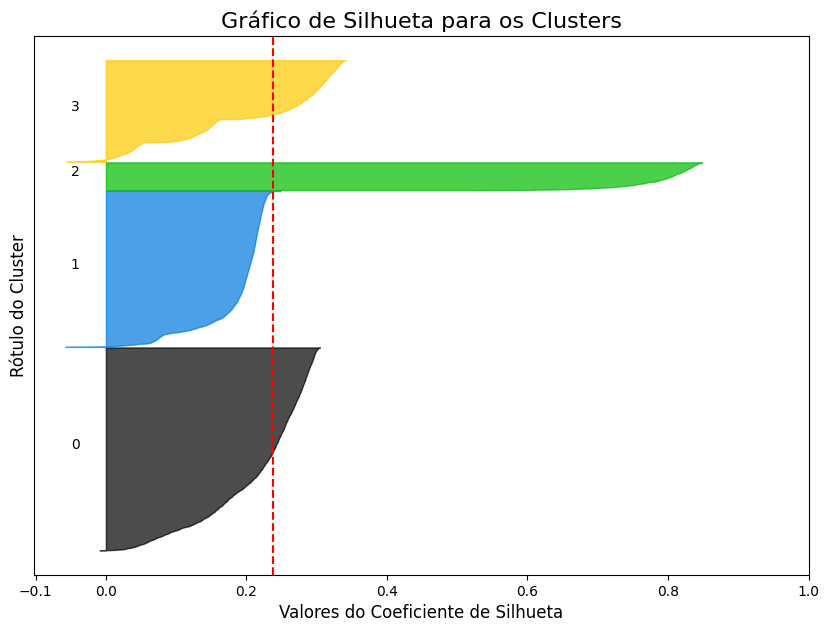

In [24]:
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Supondo que 'df_completo' e 'clusters' foram gerados a partir do DataFrame limpo de 9293 jogadores.

# --- RE-PREPARAR OS DADOS PARA O PCA E CLUSTERIZAÇÃO COM df_completo ---
# Selecionando as colunas para o PCA (excluindo 'college')
colunas_para_pca = ['position', 'heightInches', 'weight', 'ageAtDraft', 'round']
df_pca_source_completo = df_completo[colunas_para_pca].copy()

# One-Hot Encoding para a coluna 'position'
df_pca_encoded_completo = pd.get_dummies(df_pca_source_completo, columns=['position'], drop_first=True)

# Padronização dos Dados (Scaling)
scaler = StandardScaler()
dados_scaled_completo = scaler.fit_transform(df_pca_encoded_completo)

# Reaplicar o PCA com o número de componentes definido anteriormente
# Use o mesmo número de componentes que você usou para a clusterização final (n_componentes_final)
pca_completo = PCA(n_components=n_componentes_final) # n_componentes_final = 17
componentes_principais_completo = pca_completo.fit_transform(dados_scaled_completo)

# Recriar df_para_cluster usando os dados PCA dos dados completos
df_para_cluster = pd.DataFrame(data=componentes_principais_completo,
                               columns=[f'Componente_{i}' for i in range(1, n_componentes_final + 1)])

# --- RECALCULAR OS VALORES DE SILHUETA COM OS DADOS CORRETOS ---
# Calcula o score médio e os scores individuais usando o 'df_para_cluster'
# que foi criado a partir dos dados completos
silhouette_avg = silhouette_score(df_para_cluster, clusters)
sample_silhouette_values = silhouette_samples(df_para_cluster, clusters)

print(f"O score médio de silhueta para {n_clusters_final} clusters é: {silhouette_avg:.4f}")

# --- Geração do Gráfico de Silhueta ---
fig, ax1 = plt.subplots(1, 1, figsize=(10, 7))
y_lower = 10

for i in range(n_clusters_final):
    # Agrega os scores de silhueta para as amostras de cada cluster e os ordena
    ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    # Define a cor para o cluster
    color = cm.nipy_spectral(float(i) / n_clusters_final)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Adiciona o número do cluster no meio da "faca"
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Atualiza o y_lower para o próximo cluster
    y_lower = y_upper + 10

ax1.set_title("Gráfico de Silhueta para os Clusters", fontsize=16)
ax1.set_xlabel("Valores do Coeficiente de Silhueta", fontsize=12)
ax1.set_ylabel("Rótulo do Cluster", fontsize=12)

# Adiciona a linha vertical para o score médio
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Limpa os ticks do eixo y
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
plt.show()

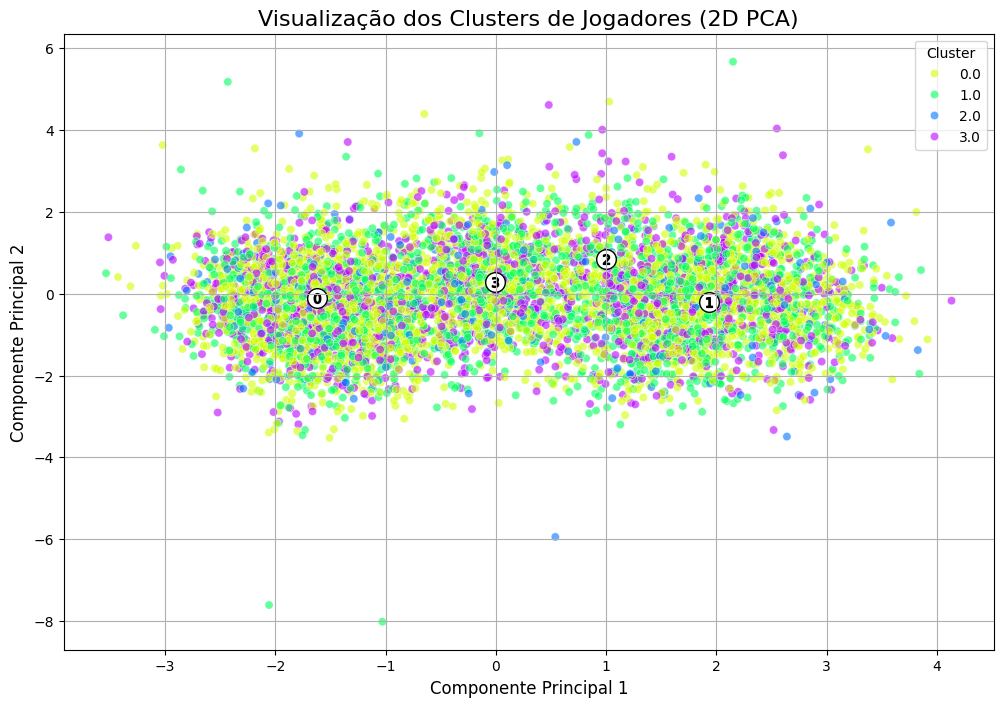

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- CORREÇÃO: Garanta que df_para_cluster seja um DataFrame ---
# Supondo que 'componentes_principais_final' é o array NumPy que saiu do seu PCA
# e 'n_componentes_final' é o número de componentes que você usou (ex: 41 ou 17).

# Ensure that 'df_para_cluster' is created using the PCA output with the correct number of components (n_componentes_final=17)
# And that 'df_completo' is used for the hue argument in the scatterplot.

df_para_cluster = pd.DataFrame(data=componentes_principais_final,
                               columns=[f'Componente_{i}' for i in range(1, n_componentes_final + 1)])


# --- Visualização dos Clusters (usando o DataFrame corrigido) ---

plt.figure(figsize=(12, 8))

# O código de plotagem agora funcionará, pois df_para_cluster é um DataFrame.
# Usaremos os nomes das colunas para mais clareza.
sns.scatterplot(
    x=df_para_cluster['Componente_1'],
    y=df_para_cluster['Componente_2'],
    hue=df_completo['Cluster'], # Usando o df_completo que tem os dados limpos
    palette=sns.color_palette("hsv", n_colors=4),
    legend="full",
    alpha=0.6
)

# Adicionando os centróides (o centro de cada cluster) ao gráfico
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker='o',
    c="white",
    alpha=1,
    s=200,
    edgecolor='k'
)

for i, c in enumerate(centroids):
    plt.scatter(c[0], c[1], marker=f'${i}$', alpha=1, s=50, edgecolor='k')

plt.title('Visualização dos Clusters de Jogadores (2D PCA)', fontsize=16)
plt.xlabel('Componente Principal 1', fontsize=12)
plt.ylabel('Componente Principal 2', fontsize=12)
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

# **5. Análises gráficas dos clusters**

## 5.1 Mapa de calor

O mapa de calor é uma ótima maneira de comparar os perfis dos 4 clusters de forma visual e rápida. As cores nos ajudarão a identificar facilmente quais características (atributos) são mais fortes ou mais fracas em cada grupo de jogadores.

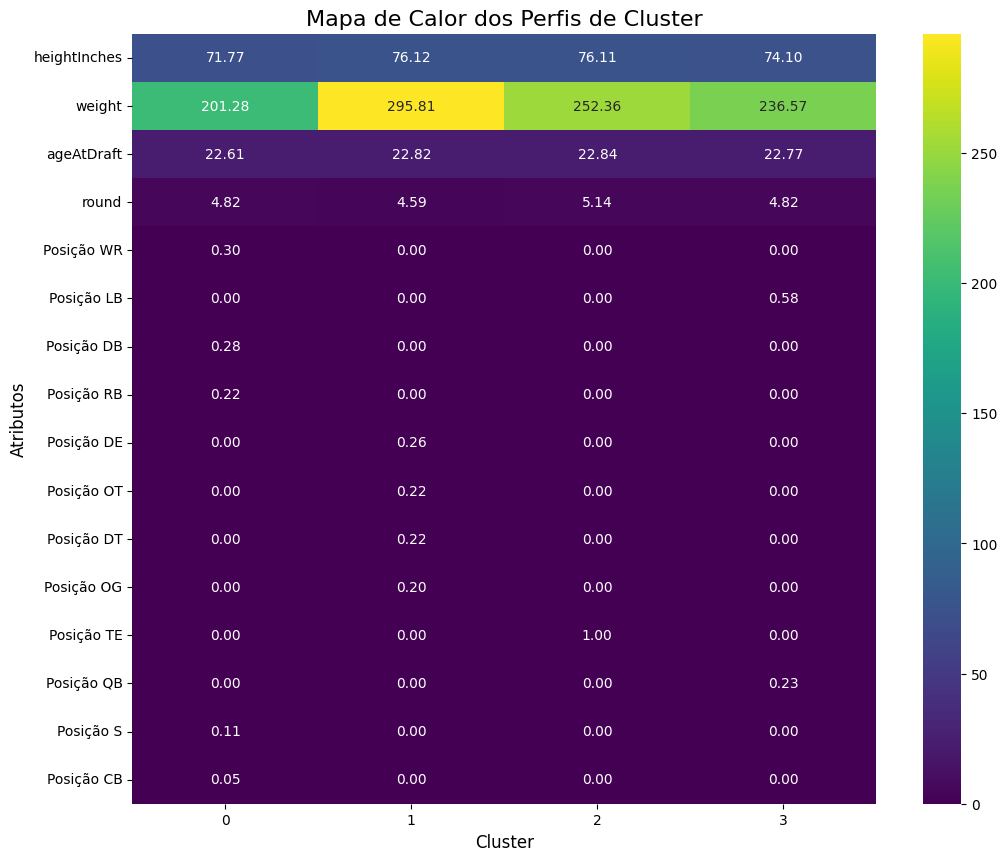

In [43]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Supondo que 'df_completo' é o DataFrame limpo com a coluna 'Cluster'.
# Supondo que 'df_perfis_clusters_final' é o DataFrame com os perfis médios dos clusters.

# --- Etapa 1: Preparar os dados para o heatmap ---

# Primeiro, fazemos o One-Hot Encoding da coluna de posição para transformá-la em números
df_heatmap_source = pd.get_dummies(df_completo, columns=['position'])

# CORREÇÃO: Remover a coluna 'college' antes de calcular a média
df_heatmap_source = df_heatmap_source.drop('college', axis=1)

# Agora, calculamos a média de todos os atributos para cada cluster.
# Para colunas numéricas, será a média (ex: peso médio).
# Para as colunas de posição (que agora são 0s e 1s), a média será a porcentagem de ocorrência.
df_heatmap_data = df_heatmap_source.groupby('Cluster').mean()


# --- Etapa 2: Selecionar os atributos mais relevantes para visualizar ---

# CORREÇÃO: Selecionar as top 12 posições mais comuns no df_completo
top_positions_overall = df_completo['position'].value_counts().nlargest(12).index
colunas_posicao_relevantes = [f'position_{pos}' for pos in top_positions_overall]

# Selecionamos os atributos físicos e as posições mais relevantes
atributos_para_heatmap = ['heightInches', 'weight', 'ageAtDraft', 'round'] + colunas_posicao_relevantes

# Filtrar o DataFrame para incluir apenas as colunas selecionadas
df_heatmap_final = df_heatmap_data[atributos_para_heatmap]


# Renomeamos as colunas de posição para ficarem mais legíveis
df_heatmap_final = df_heatmap_final.rename(columns=lambda x: x.replace('position_', 'Posição '))

# --- Etapa 3: Gerar o Mapa de Calor ---

plt.figure(figsize=(12, 10))
sns.heatmap(
    df_heatmap_final.transpose(), # Transpomos para que os atributos fiquem no eixo Y
    annot=True,       # Mostra os números dentro de cada célula
    cmap='viridis',   # Paleta de cores
    fmt=".2f"         # Formata os números para duas casas decimais
)

plt.title('Mapa de Calor dos Perfis de Cluster', fontsize=16)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Atributos', fontsize=12)
plt.show()

## 5.2 Mapa de radar

Este tipo de gráfico é perfeito para comparar os 4 perfis de cluster ao mesmo tempo, mostrando seus "pontos fortes" em diferentes atributos. Ele nos dará uma visão clara e comparativa das características de cada grupo.

In [28]:
import pandas as pd
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler

# Supondo que 'df_perfis_clusters_final' é o DataFrame com os perfis de cada cluster.

# --- Etapa 1: Preparar os dados para o Diagrama de Radar ---

# CORREÇÃO: Usando os nomes originais das colunas
colunas_numericas_originais = ['heightInches', 'weight', 'ageAtDraft', 'round']
df_radar = df_perfis_clusters_final[colunas_numericas_originais].copy()

# O Diagrama de Radar funciona melhor quando os dados estão na mesma escala.
# Vamos normalizar os valores entre 0 e 1.
scaler = MinMaxScaler()
df_radar_scaled = pd.DataFrame(scaler.fit_transform(df_radar), columns=df_radar.columns)

# Adicionamos os nomes dos clusters de volta
df_radar_scaled['Cluster'] = df_perfis_clusters_final.index


# --- Etapa 2: Gerar o Diagrama de Radar ---

fig = go.Figure()

# Lista de cores para cada cluster
cores = ['lightcoral', 'skyblue', 'gold', 'limegreen']

for i, row in df_radar_scaled.iterrows():
    cluster_num = row['Cluster']
    # A última coluna é o nome do cluster, então pegamos todas menos ela para os valores
    valores = row.drop('Cluster').tolist()
    # Para fechar o radar, repetimos o primeiro valor no final
    valores.append(valores[0])

    atributos = df_radar.columns.tolist()
    atributos.append(atributos[0]) # Repete o primeiro atributo para fechar o laço

    fig.add_trace(go.Scatterpolar(
        r=valores,
        theta=atributos,
        fill='toself',
        name=f'Cluster {cluster_num}',
        line=dict(color=cores[i])
    ))

fig.update_layout(
  title='Diagrama de Radar Comparativo dos Perfis de Cluster',
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 1]
    )),
  showlegend=True,
  height=700
)

fig.show()

## 5.3 Gráficos de Barras Comparativos

Agora vamos comparar de forma mais direta os atributos mais importantes entre os clusters.

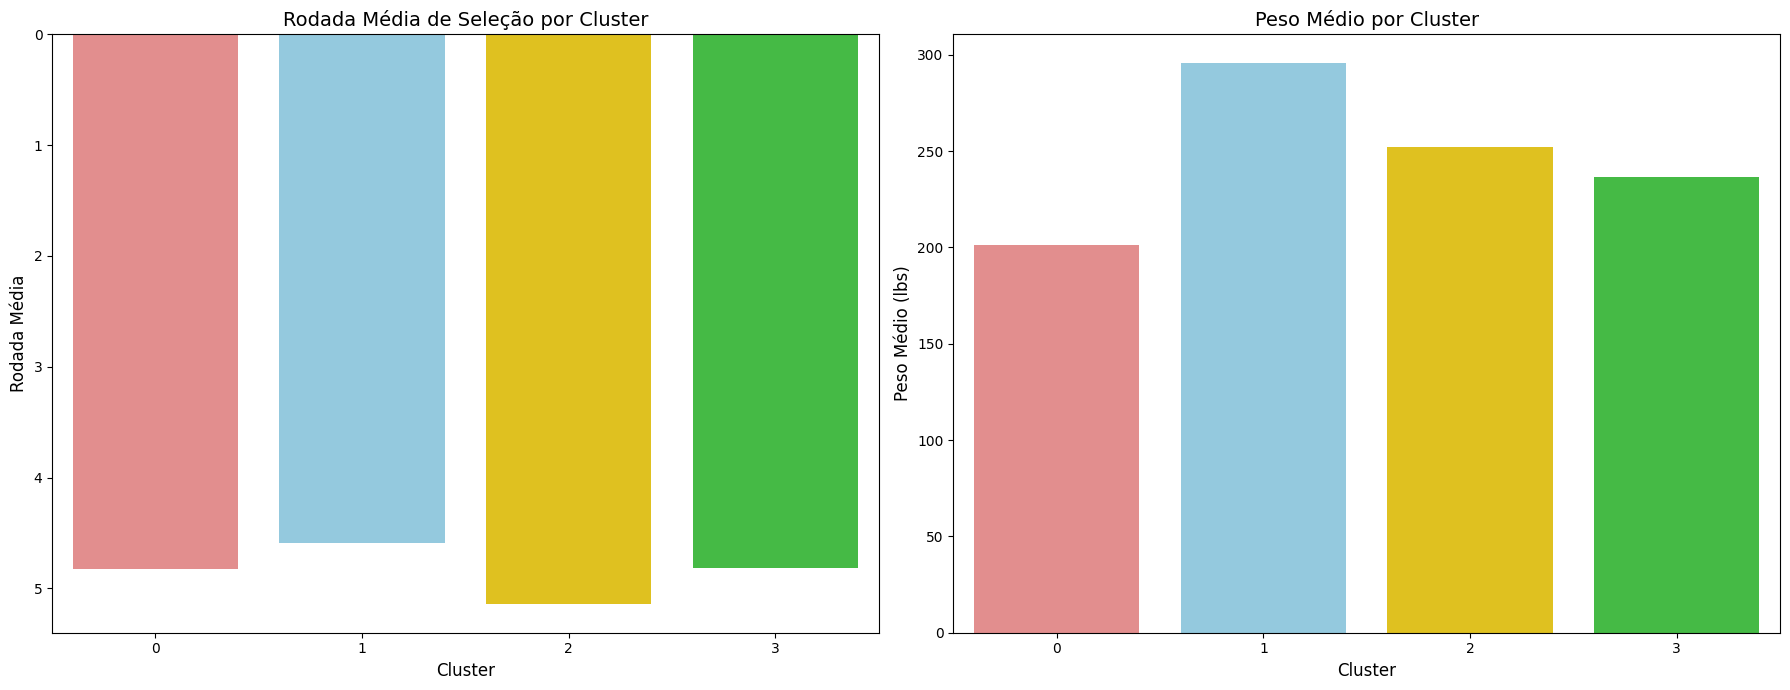

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

# Supondo que 'df_perfis_clusters_final' ainda está disponível.

# --- Gráficos de Barras ---
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
cores = ['lightcoral', 'skyblue', 'gold', 'limegreen']

# Gráfico 1: Rodada Média por Cluster
# CORREÇÃO: Usando o nome original da coluna 'round' e atribuindo 'x' a 'hue' com legend=False
sns.barplot(x=df_perfis_clusters_final.index, y='round', data=df_perfis_clusters_final, ax=axes[0], palette=cores, hue=df_perfis_clusters_final.index, legend=False)
axes[0].set_title('Rodada Média de Seleção por Cluster', fontsize=14)
axes[0].set_xlabel('Cluster', fontsize=12)
axes[0].set_ylabel('Rodada Média', fontsize=12)
axes[0].invert_yaxis()


# Gráfico 2: Peso Médio por Cluster
# CORREÇÃO: Usando o nome original da coluna 'weight' e atribuindo 'x' a 'hue' com legend=False
sns.barplot(x=df_perfis_clusters_final.index, y='weight', data=df_perfis_clusters_final, ax=axes[1], palette=cores, hue=df_perfis_clusters_final.index, legend=False)
axes[1].set_title('Peso Médio por Cluster', fontsize=14)
axes[1].set_xlabel('Cluster', fontsize=12)
axes[1].set_ylabel('Peso Médio (lbs)', fontsize=12)


plt.tight_layout()
plt.show()

## 5.4 Distribuição de Peso Dentro de Cada Cluster (Histogramas)

--- Gerando Histogramas de Distribuição de Peso por Cluster ---


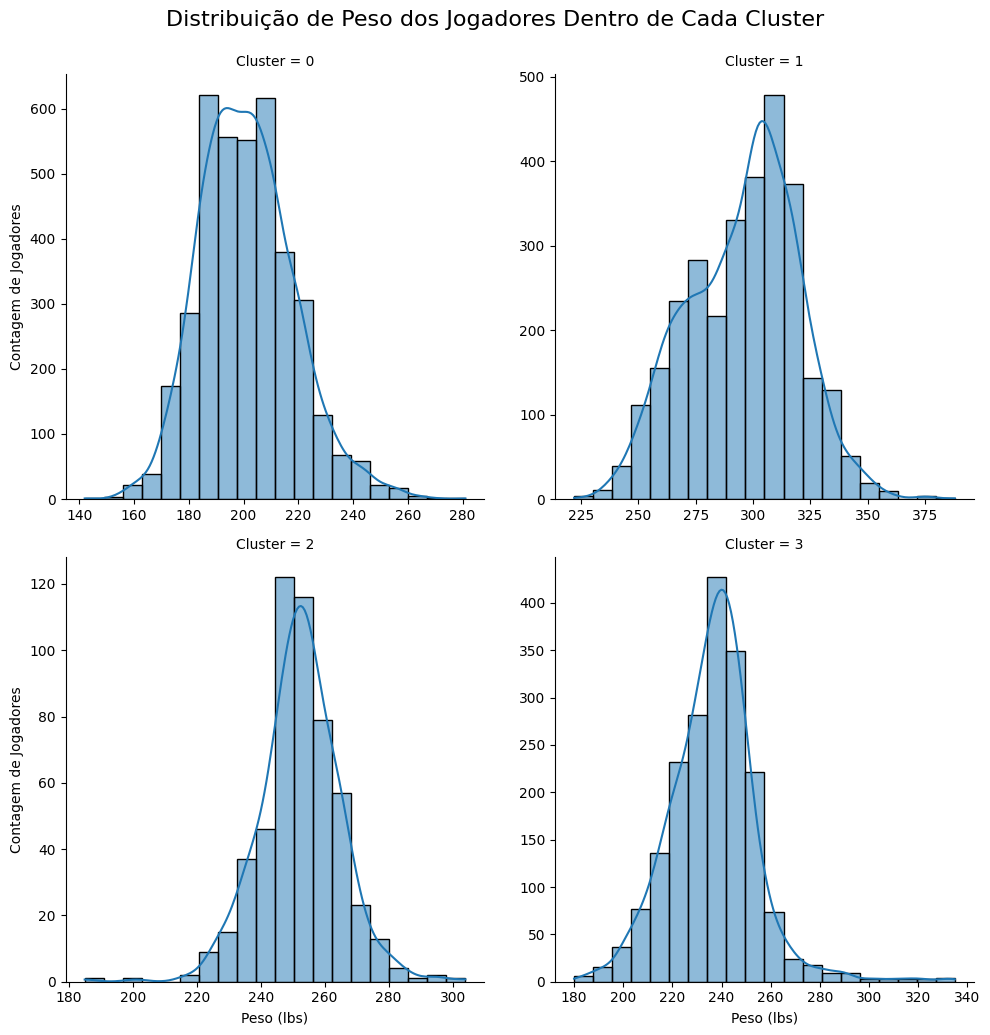

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

print("--- Gerando Histogramas de Distribuição de Peso por Cluster ---")

# Usamos o FacetGrid para criar um gráfico para cada cluster
g = sns.FacetGrid(df_completo, col="Cluster", col_wrap=2, height=5, sharex=False, sharey=False)
g.map(sns.histplot, 'weight', bins=20, kde=True)

g.fig.suptitle('Distribuição de Peso dos Jogadores Dentro de Cada Cluster', y=1.03, fontsize=16)
g.set_axis_labels("Peso (lbs)", "Contagem de Jogadores")
plt.show()

## 5.5 Composição de Posições por Cluster (Gráfico de Barras Empilhadas)

--- Gerando Gráfico de Composição de Posições por Cluster (Paleta 'Paired') ---


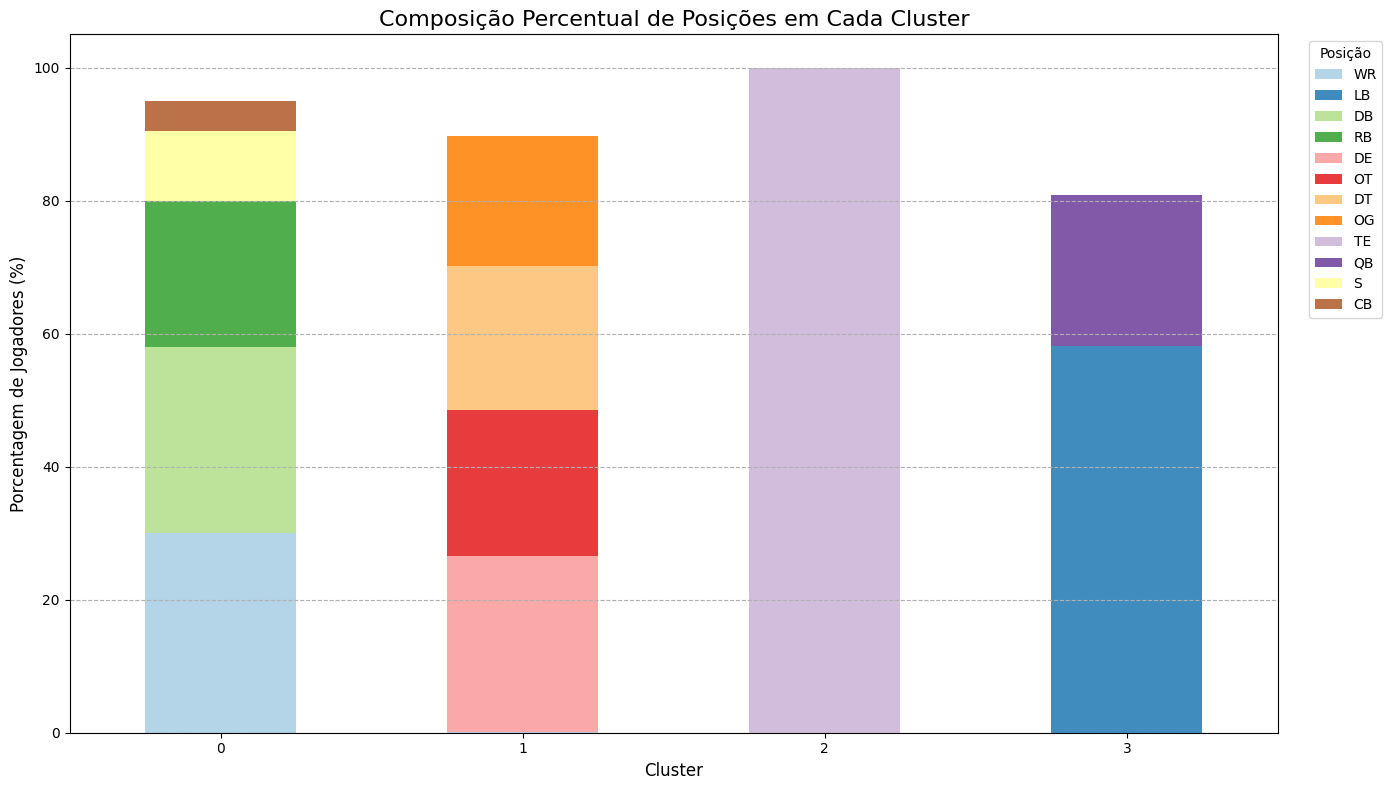

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

# Supondo que 'df_completo' está disponível.
print("--- Gerando Gráfico de Composição de Posições por Cluster (Paleta 'Paired') ---")

# Cria uma tabela de contingência com a contagem de posições por cluster
cross_tab = pd.crosstab(df_completo['Cluster'], df_completo['position'])

# Normaliza os dados para obter a porcentagem (de 0 a 100)
cross_tab_perc = cross_tab.div(cross_tab.sum(axis=1), axis=0) * 100

# Seleciona as 12 posições mais comuns para o gráfico
top_positions = df_completo['position'].value_counts().nlargest(12).index
cross_tab_perc_top = cross_tab_perc[top_positions]

# Gera o gráfico de barras empilhadas com a paleta de cores 'Paired'
cross_tab_perc_top.plot(kind='bar', stacked=True, figsize=(14, 8),
                        colormap='Paired',
                        alpha=0.85)

plt.title('Composição Percentual de Posições em Cada Cluster', fontsize=16)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Porcentagem de Jogadores (%)', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Posição', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.grid(axis='y', linestyle='--') # <-- LINHA CORRIGIDA
plt.tight_layout()
plt.show()

# **6. Análise Descritiva dos Clusters**

*   Finalmente, realizamos uma análise descritiva detalhada de cada cluster, calculando as estatísticas sumárias (média, desvio padrão, mínimo, máximo) para os atributos numéricos e identificando as posições mais frequentes em cada grupo.

*   Interpretamos os perfis de cada cluster com base nessas estatísticas e visualizações, identificando características distintas em termos de tamanho, peso e posições típicas.

Este foi o caminho que seguimos para agrupar os jogadores e entender os diferentes perfis presentes no Draft da NFL com base nos dados que analisamos.



## 6.1 Interpretando por combinações de atributos

*   **Cluster 0:** Este cluster tem a menor altura e peso médios. A posição mais frequente é WR (Wide Receiver), seguida por DB (Defensive Back) e RB (Running Back). A rodada média de seleção é por volta da 5ª rodada, com a moda sendo a 7ª rodada, indicando que jogadores deste cluster são frequentemente selecionados em rodadas intermediárias a tardias. Este cluster parece agrupar jogadores de posições mais ágeis e tipicamente mais leves.

*   **Cluster 1:** Este cluster se destaca pela maior altura e maior peso. A posição mais frequente é DE (Defensive End), com alta frequência também de OT (Offensive Tackle), DT (Defensive Tackle) e OG (Offensive Guard). A rodada média é próxima da 4ª rodada. Este cluster parece representar jogadores de linha ofensiva e defensiva, que geralmente são maiores e mais pesados.

*   **Cluster 2:** Este cluster é dominado por jogadores da posição TE (Tight End). Eles possuem a segunda maior altura (ficando atrás dos jogares do cluster 1) e peso médios intermediários em comparação com os outros clusters, sendo mais altos e pesados que os do Cluster 0, mas menos pesados que os do Cluster 1. A rodada média é por volta da 5ª rodada. Este cluster claramente agrupa os jogadores de Tight End.

*   **Cluster 3:** Este cluster apresenta altura e peso médios intermediários, sendo mais pesados que o Cluster 0 e mais leves que o Cluster 1. A posição mais frequente é LB (Linebacker), seguida por QB (Quarterback) e FB (Fullback). A rodada média de seleção é por volta da 5ª rodada. Este cluster parece agrupar jogadores de posições que exigem uma combinação de tamanho, força e agilidade, como Linebackers e Quarterbacks.

In [34]:
# Análise Descritiva por Cluster
print("\n--- Análise Descritiva por Cluster ---")
display(df_completo.groupby('Cluster').agg({
    'heightInches': ['mean', 'std', 'min', 'max'],
    'weight': ['mean', 'std', 'min', 'max'],
    'ageAtDraft': ['mean', 'std', 'min', 'max'],
    'round': ['mean', 'std', 'min', 'max', lambda x: x.mode()[0]], # Adiciona a moda para a rodada
    'position': lambda x: x.mode()[0] # Adiciona a posição mais frequente (moda)
}).rename(columns={'<lambda_0>': 'most_frequent_round', '<lambda_1>': 'most_frequent_position'}))

print("\n" + "="*50 + "\n")
print("--- Distribuição de Posições por Cluster (Top 5) ---")
# Para cada cluster, mostre as 5 posições mais frequentes
for i in sorted(df_completo['Cluster'].unique()):
    print(f"\nCluster {i}:")
    display(df_completo[df_completo['Cluster'] == i]['position'].value_counts().head())


--- Análise Descritiva por Cluster ---


heightInches                            weight                    \
                mean       std   min   max        mean        std    min   
Cluster                                                                    
0          71.768792  1.989196  65.0  78.0  201.279938  17.260045  142.0   
1          76.117390  1.610659  68.0  81.0  295.813993  23.885072  222.0   
2          76.107750  1.420133  69.0  80.0  252.359168  12.728946  185.0   
3          74.098810  1.639024  68.0  80.0  236.568546  17.933541  180.0   

               ageAtDraft                                     round            \
           max       mean       std        min        max      mean       std   
Cluster                                                                         
0        281.0  22.609828  0.821975  19.523288  27.419178  4.823224  2.694613   
1        388.0  22.823190  0.835897  19.890411  28.487671  4.591995  2.660089   
2        304.0  22.836600  0.845988  20.471233  26.802740  5.143667  2.565462   
3        335.0  22.767149  0.821797  20.005479  28.742466  4.818934  2.717232   

                                       position  
         min   max most_frequent_round <lambda>  
Cluster                                          
0        1.0  12.0                 7.0       WR  
1        1.0  12.0                 7.0       DE  
2        1.0  12.0                 7.0       TE  
3        1.0  12.0                 7.0       LB



--- Distribuição de Posições por Cluster (Top 5) ---

Cluster 0:


,count
position,
WR,1158
DB,1079
RB,846
S,409
CB,175



Cluster 1:


,count
position,
DE,786
OT,655
DT,642
OG,580
OC,138



Cluster 2:


,count
position,
TE,529



Cluster 3:


,count
position,
LB,1124
QB,438
FB,133
OLB,85
NT,60


## 6.2 Análise da distribuição de Idade no Draft

A análise da distribuição de Idade no Draft por cluster mostrou que a idade não foi um fator primário de separação, com medianas semelhantes entre os grupos. Da mesma forma, a Rodada do Draft, embora apresente pequenas variações nas distribuições, não segregou fortemente os clusters, indicando que jogadores com perfis físicos e de posição semelhantes podem ser selecionados em diferentes etapas do draft.

--- Gerando Gráficos de Boxplot de Idade e Rodada por Cluster ---


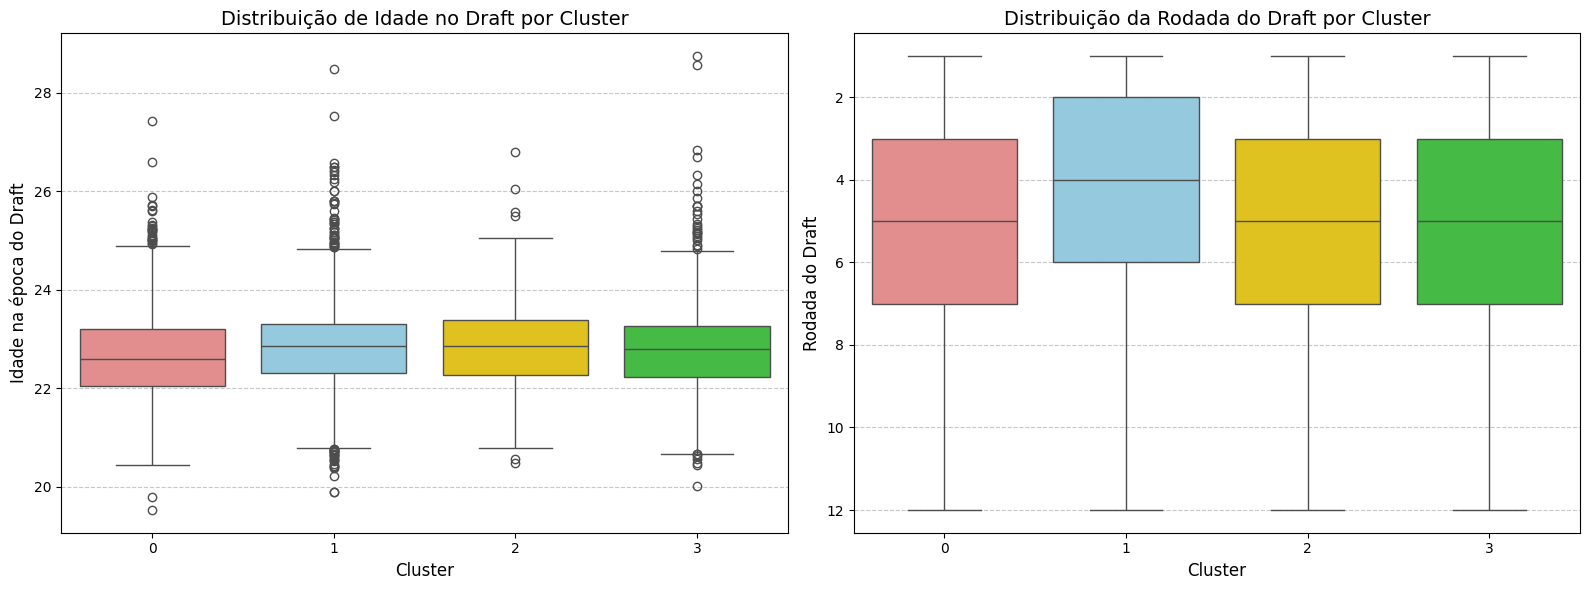

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

# Supondo que 'df_completo' é o seu DataFrame com os dados limpos e a coluna 'Cluster'.

print("--- Gerando Gráficos de Boxplot de Idade e Rodada por Cluster ---")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
cores = ['lightcoral', 'skyblue', 'gold', 'limegreen'] # Mantendo a mesma paleta de cores

# Boxplot para Idade no Draft por Cluster
# CORREÇÃO: Atribuindo 'x' a 'hue' e definindo legend=False para remover FutureWarning
sns.boxplot(x='Cluster', y='ageAtDraft', data=df_completo, ax=axes[0], palette=cores, hue='Cluster', legend=False)
axes[0].set_title('Distribuição de Idade no Draft por Cluster', fontsize=14)
axes[0].set_xlabel('Cluster', fontsize=12)
axes[0].set_ylabel('Idade na época do Draft', fontsize=12)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)


# Boxplot para Rodada do Draft por Cluster
# CORREÇÃO: Atribuindo 'x' a 'hue' e definindo legend=False para remover FutureWarning
sns.boxplot(x='Cluster', y='round', data=df_completo, ax=axes[1], palette=cores, hue='Cluster', legend=False)
axes[1].set_title('Distribuição da Rodada do Draft por Cluster', fontsize=14)
axes[1].set_xlabel('Cluster', fontsize=12)
axes[1].set_ylabel('Rodada do Draft', fontsize=12)
# Invertendo o eixo Y para que a Rodada 1 fique no topo
axes[1].invert_yaxis()
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## 6.3 Relação entre a faculdade de origem dos jogadores e os clusters

### 6.3.1 Análise da distribuição de faculdades por cluster

Calcular a contagem ou porcentagem de jogadores de cada faculdade dentro de cada cluster.


In [36]:
# Criar a tabela de contingência de faculdades por cluster
faculdade_cluster_counts = pd.crosstab(df_completo['college'], df_completo['Cluster'])

# Normalizar a tabela para obter as porcentagens dentro de cada cluster (soma por linha)
faculdade_cluster_perc = faculdade_cluster_counts.div(faculdade_cluster_counts.sum(axis=1), axis=0) * 100

# Exibir as primeiras linhas das tabelas
print("--- Contagem de jogadores por Faculdade e Cluster ---")
display(faculdade_cluster_counts.head())

print("\n--- Porcentagem de jogadores por Faculdade dentro de cada Cluster ---")
display(faculdade_cluster_perc.head())

--- Contagem de jogadores por Faculdade e Cluster ---


Cluster,0,1,2,3
college,,,,
Abilene Christian (TX),6,1,0,0
Air Force Academy,1,3,0,1
Akron,5,3,1,2
Alabama,66,56,8,42
Alabama A&M,1,4,0,2



--- Porcentagem de jogadores por Faculdade dentro de cada Cluster ---


Cluster,0,1,2,3
college,,,,
Abilene Christian (TX),85.714286,14.285714,0.000000,0.000000
Air Force Academy,20.000000,60.000000,0.000000,20.000000
Akron,45.454545,27.272727,9.090909,18.181818
Alabama,38.372093,32.558140,4.651163,24.418605
Alabama A&M,14.285714,57.142857,0.000000,28.571429


### 6.3.2 Identificação das faculdades mais representativas


In [37]:
# 1. Identify the top 10 colleges based on the total number of players in df_completo.
top_colleges = df_completo['college'].value_counts().nlargest(10).index
print("--- Top 10 Faculdades por número total de jogadores draftados (Dados Completos) ---")
display(df_completo['college'].value_counts().nlargest(10))

# 2. Filter the faculdade_cluster_counts DataFrame to include only these top 10 colleges.
faculdade_cluster_counts_top = faculdade_cluster_counts.loc[top_colleges]

# 3. Filter the faculdade_cluster_perc DataFrame to include only these top 10 colleges.
faculdade_cluster_perc_top = faculdade_cluster_perc.loc[top_colleges]

# 4. Display the total number of players from each of these top colleges and their distribution across the clusters.
print("\n--- Contagem de jogadores por Top 10 Faculdades e Cluster (Dados Completos) ---")
display(faculdade_cluster_counts_top)

# 5. Display the percentage distribution of players from each of these top colleges across the clusters.
print("\n--- Distribuição Percentual de jogadores por Top 10 Faculdades dentro de cada Cluster (Dados Completos) ---")
display(faculdade_cluster_perc_top)

--- Top 10 Faculdades por número total de jogadores draftados (Dados Completos) ---


,count
college,
Miami (FL),204
Ohio State,194
USC,191
Florida State,187
Florida,185
Notre Dame,173
Alabama,172
Tennessee,169
Louisiana State,164



--- Contagem de jogadores por Top 10 Faculdades e Cluster (Dados Completos) ---


Cluster,0,1,2,3
college,,,,
Miami (FL),86,63,17,38
Ohio State,88,53,7,46
USC,72,52,13,54
Florida State,78,55,5,49
Florida,77,68,6,34
Notre Dame,65,62,16,30
Alabama,66,56,8,42
Tennessee,74,53,5,37
Louisiana State,77,51,7,29



--- Distribuição Percentual de jogadores por Top 10 Faculdades dentro de cada Cluster (Dados Completos) ---


Cluster,0,1,2,3
college,,,,
Miami (FL),42.156863,30.882353,8.333333,18.627451
Ohio State,45.360825,27.319588,3.608247,23.711340
USC,37.696335,27.225131,6.806283,28.272251
Florida State,41.711230,29.411765,2.673797,26.203209
Florida,41.621622,36.756757,3.243243,18.378378
Notre Dame,37.572254,35.838150,9.248555,17.341040
Alabama,38.372093,32.558140,4.651163,24.418605
Tennessee,43.786982,31.360947,2.958580,21.893491
Louisiana State,46.951220,31.097561,4.268293,17.682927


### 6.3.3 Visualização da relação faculdade-cluster

--- Gerando Gráfico de Barras Empilhadas da Distribuição de Faculdades por Cluster ---


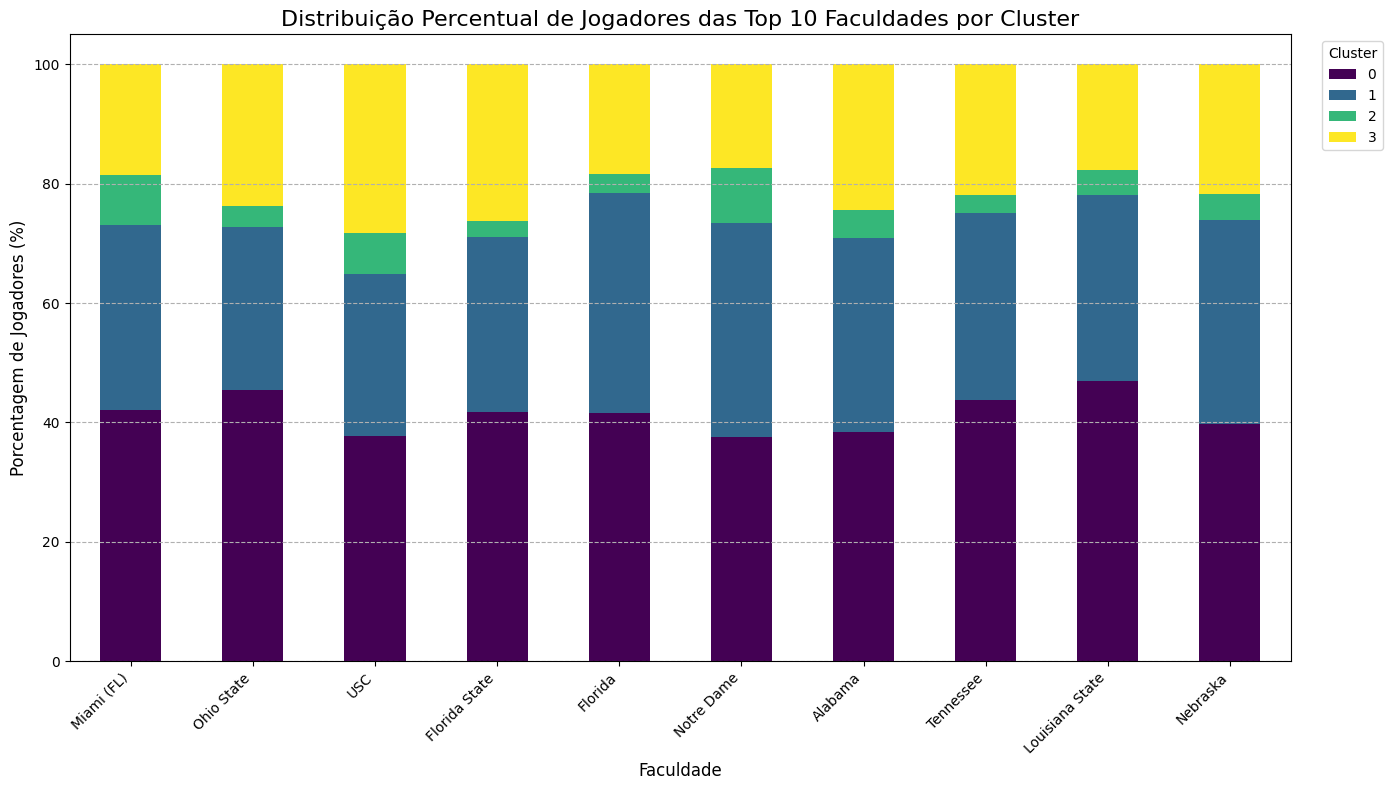

In [38]:
import matplotlib.pyplot as plt

# Assuming 'faculdade_cluster_perc_top' DataFrame is already available

print("--- Gerando Gráfico de Barras Empilhadas da Distribuição de Faculdades por Cluster ---")

faculdade_cluster_perc_top.plot(kind='bar', stacked=True, figsize=(14, 8), colormap='viridis')

plt.title('Distribuição Percentual de Jogadores das Top 10 Faculdades por Cluster', fontsize=16)
plt.xlabel('Faculdade', fontsize=12)
plt.ylabel('Porcentagem de Jogadores (%)', fontsize=12)
plt.xticks(rotation=45, ha='right') # Rotate labels for better readability
plt.legend(title='Cluster', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

### **Principais Descobertas da Análise de Dados**

*   As 10 faculdades com o maior número de jogadores draftados são Louisiana State (LSU), Ohio State, Tennessee, Florida, Notre Dame, Texas, Michigan, Georgia, Penn State e Miami (FL).

*   Louisiana State (LSU), Ohio State e Tennessee apresentam uma porcentagem maior de seus jogadores draftados no Cluster 0, que é caracterizado por jogadores menores e mais leves, tipicamente em posições como Wide Receiver, Defensive Back e Running Back.

*   Florida e Notre Dame têm uma porcentagem ligeiramente maior de seus jogadores draftados no Cluster 1, que consiste em jogadores maiores e mais pesados, comumente Linemen (Defensive End, Offensive Tackle, Defensive Tackle, Offensive Guard).

*   Notre Dame também tem uma porcentagem relativamente maior de jogadores no Cluster 2, o cluster composto principalmente por Tight Ends.


### **Insights**

*   Embora as principais faculdades geralmente produzam uma gama diversificada de jogadores, há alguma indicação de que certas faculdades podem ter uma leve tendência a desenvolver jogadores que se encaixam em perfis físicos e posições específicas, conforme refletido em sua distribuição de clusters.

*   Análises futuras poderiam envolver o exame das posições específicas jogadas pelos jogadores dessas faculdades dentro de cada cluster para confirmar se a distribuição observada se alinha com as tendências posicionais.






In [39]:
print(f"O dataframe final possui {df_completo.shape[0]} linhas e {df_completo.shape[1]} colunas.")

O dataframe final possui 9293 linhas e 7 colunas.
